# Explore here

In [2]:
# Your code here
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from pickle import dump
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 1. Problem statement and data collection

##### Inspiration
 - What can we learn about different hosts and areas?
 - What can we learn from predictions? (ex: locations, prices, reviews, etc)
 - Which hosts are the busiest and why?
 - Is there any noticeable difference of traffic among different areas and what could be the reason for it?

In [5]:
df = pd.read_csv("../data/raw/AB_NYC_2019.csv")
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


----------------------------------------------------------------

### 2. Exploration and data cleaning 

#### 2.1 Understanding the features:
- 'id' - Rental ID -> n
- 'name' - House/Apartment name -> c
- 'host_id' - Host ID -> n
- 'host_name' - Host Name -> c
- 'neighbourhood_group' - NYC Region -> c
- 'neighbourhood' - NYC Neighbourhood -> c
- 'latitude' - Lat -> n
- 'longitude' - Lon -> n
- 'room_type' - Room type -> c
- 'price' - Price per night -> n
- 'minimum_nights' - Minimum stay nights -> n
- 'number_of_reviews' - Total number of reviews -> n
- 'last_review' - Last time reviewed -> n
- 'reviews_per_month' - Reviews per month -> n
- 'calculated_host_listings_count' - Total listings by the same host -> n
- 'availability_365' - Days available during a year -> n

'* n - numerical / c - categorical 

In [9]:
print('Our dataframe contains {} rows, indicating the total number of rentals, and has a shape of {}.'.format(len(df), df.shape))

Our dataframe contains 48895 rows, indicating the total number of rentals, and has a shape of (48895, 16).


----------------------------------------------------------------

#### 2.2 Identifying Null Values and data types for each feature

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [13]:
df.isna().sum()[df.isna().sum()>0]

name                    16
host_name               21
last_review          10052
reviews_per_month    10052
dtype: int64

##### Conclusions: 
- We have 16 Nulls in our ```'name'``` feature -> Considering this is the 'apartment/rental name,' we do a 'fillna()' with any name; we will analyze later if this has repercussions when renting the apartment.  
- We have 21 Nulls in our ```'host_name'``` feature -> We will check if these hosts have other locations on rent using the host_id so that we can complete the names. 
- ```'last_review'``` and ```'reviews_per_month'``` have 10052 Nulls -> This might be new locations added recently that have not been rented yet. We will try to get more info while looking at the data. 

----------------------------------------------------------------

#### 2.3 Looking for duplicated IDs and dropping them, if any. 

In [17]:
df['id'].duplicated().sum()

0

----------------------------------------------------------------

##### 2.4 Eliminating Irrelevant Information and dealing with null values

In [20]:
df.drop(columns=['id','name', 'host_id', 'host_name', 'last_review'], axis=1, inplace=True)
df.head(3)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365


In [21]:
# Filling null values of 'reviews_per_month' feature with zero.  
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

Reasoning behind dropping those features and filling with zero our 'reviews_per_month' feature:
1. ```'id'``` / ```'name'``` / ```host_id``` /```'host_name'``` - These are mainly identifiers in our database and are not associated with the frequency of rentals at each location. In the case of 'name' and 'host_name,' null values can be found, which gave us an additional reason to remove them.
2. ```'last_review'``` - Considering we do not have other dates to associate this with, we decided to drop this feature as other relevant information related to reviews is found in our data frame ('number_of_reviews').
3. ```'reviews_per_month'``` - It seems that the only reason that feature can be null is that they have not gotten any reviews yet; therefore, instead of dropping those rows, a decision was taken to fill them with zero. 

----------------------------------------------------------------

### 3. Univariate Analysis 

#### 3.1 Dividing our dataset into categorial and numerical. 

In [26]:
# Understanding how many type of features we have
df.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [27]:
# Dividing our dataframe by numerical and categorical features
num = ['int64', 'float64']
cat = ['O']

df_num = df.select_dtypes(num)
df_cat = df.select_dtypes(cat)

In [28]:
df_cat.head(3)

,neighbourhood_group,neighbourhood,room_type
0,Brooklyn,Kensington,Private room
1,Manhattan,Midtown,Entire home/apt
2,Manhattan,Harlem,Private room


----------------------------------------------------------------

#### 3.2 Categorical Variable Analysis 

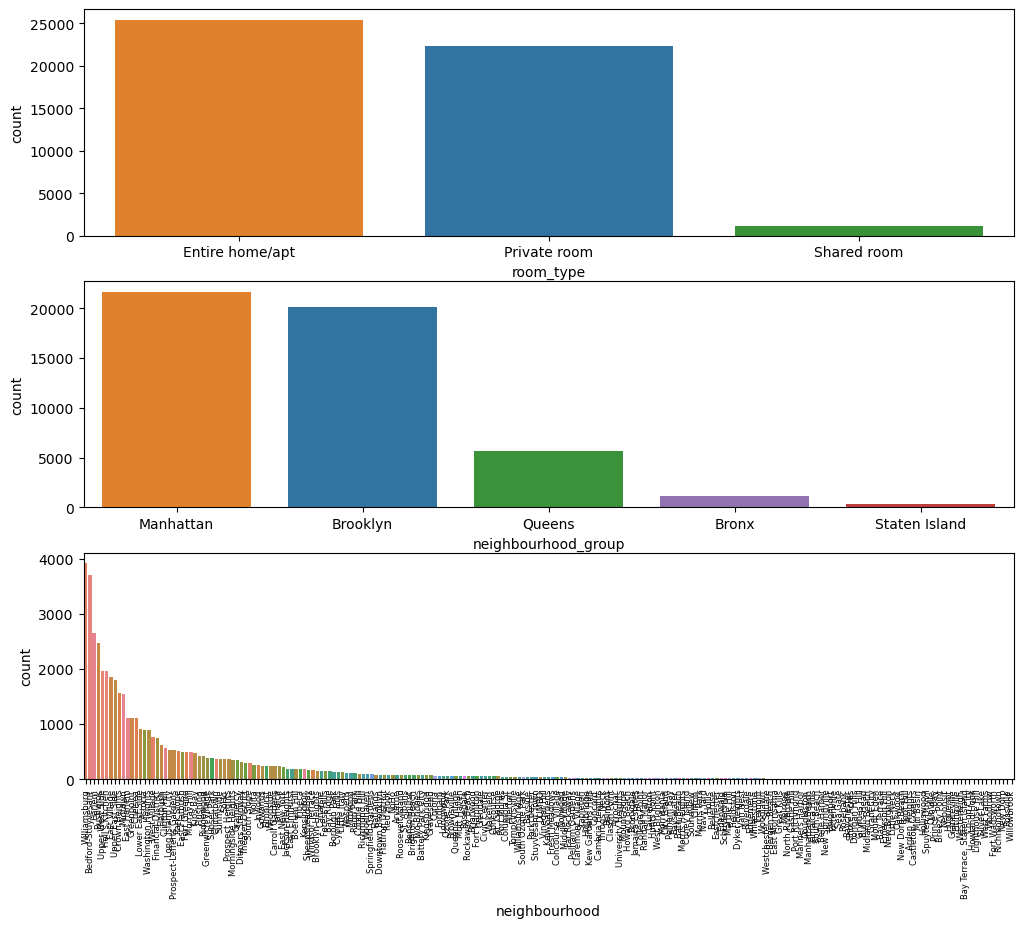

In [31]:
fig, ax = plt.subplots(3, 1, figsize = (12, 10))
sns.countplot(ax= ax[0], data = df_cat, x = "room_type", order=df_cat['room_type'].value_counts().index, hue='room_type')
sns.countplot(ax = ax[1], data = df_cat, x = "neighbourhood_group", order=df_cat['neighbourhood_group'].value_counts().index, hue='neighbourhood_group')
sns.countplot(ax = ax[2], data = df_cat, x = 'neighbourhood', order=df_cat['neighbourhood'].value_counts().index, hue='neighbourhood')
plt.xticks(rotation=90, fontsize=6)
plt.show()

##### Conclusions
- The majority of Airbnb listings are either entire homes/apartments or private rooms, suggesting a focus on accommodating tourists who prefer privacy.
- Manhattan and Brooklyn are the top locations for Airbnb rentals, likely because of their central location and higher demand from tourists.
- Specific neighborhoods like Williamsburg and Bedford-Stuyvesant are particularly popular, possibly because they offer a mix of affordability and proximity to central areas.

---------------------------------------------------------------

#### 3.3 Numerical Variable Analysis 

In [35]:
df_num.head(3)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,0.00,1,365


In [36]:
df_num['minimum_nights'].mean()

7.029962163820431

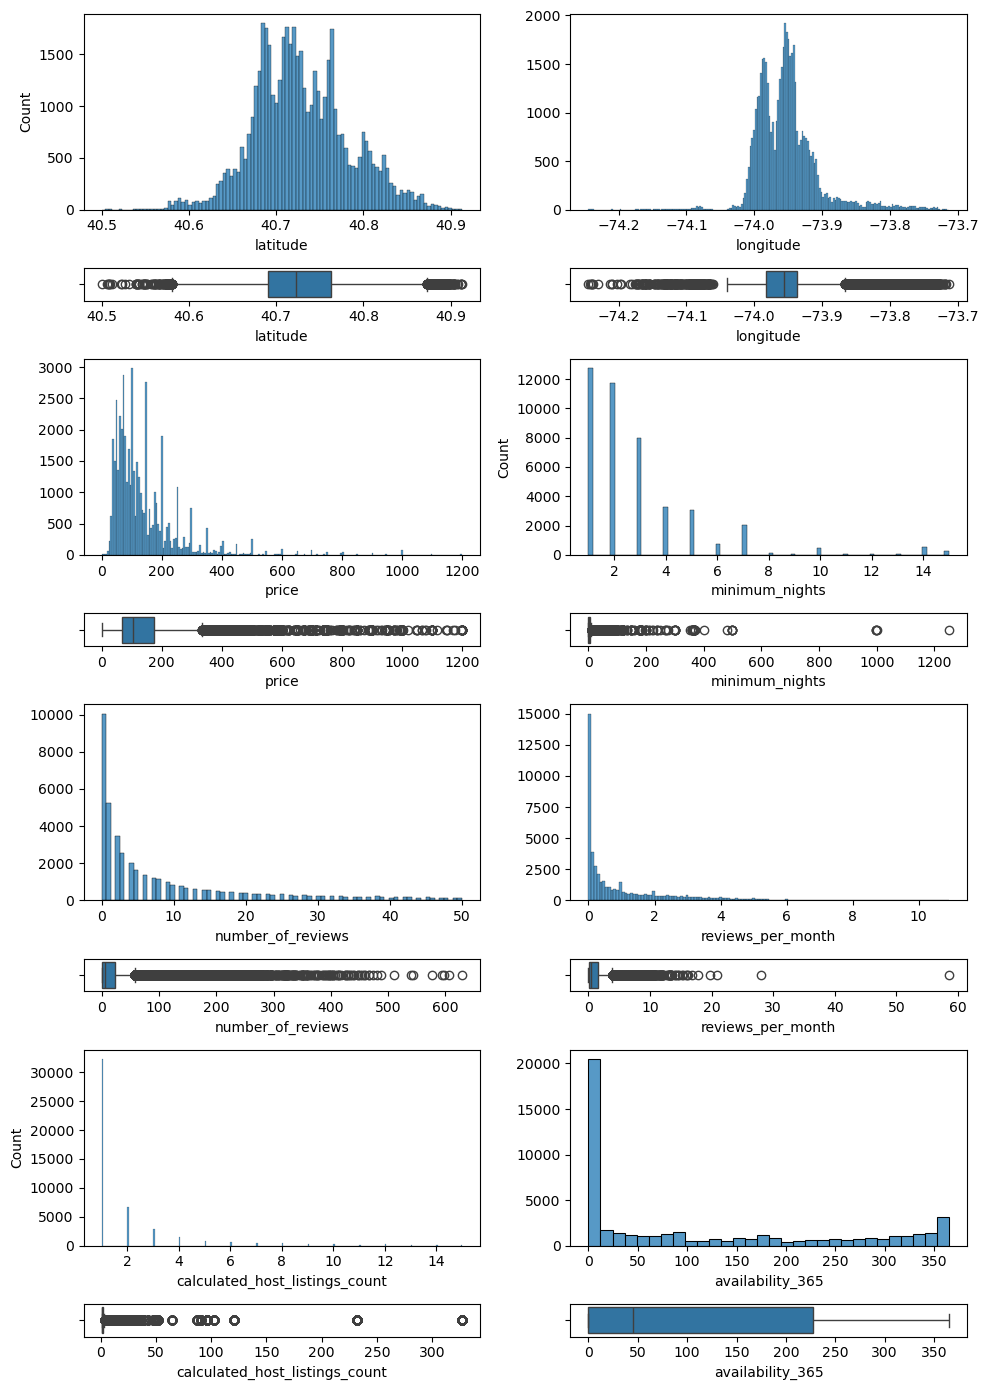

In [37]:
fig, ax = plt.subplots(8, 2, figsize=(10, 14), gridspec_kw={'height_ratios': [6, 1, 6, 1, 6, 1, 6, 1]})

# Charts first row 
sns.histplot(ax = ax[0,0], data = df_num, x='latitude')
sns.boxplot(ax = ax[1,0], data = df_num, x='latitude')
sns.histplot(ax = ax[0,1], data = df_num, x='longitude').set(ylabel = None)
sns.boxplot(ax = ax[1,1], data = df_num, x='longitude')

# Charts second row 
sns.histplot(ax = ax[2,0], data = df_num[df_num['price']<1250], x='price').set(ylabel = None)
sns.boxplot(ax = ax[3,0], data = df_num[df_num['price']<1250], x='price')
sns.histplot(ax = ax[2,1], data = df_num[df_num['minimum_nights']<16], x='minimum_nights')
sns.boxplot(ax = ax[3,1], data = df_num, x='minimum_nights')

# Charts third row 
sns.histplot(ax = ax[4,0], data = df_num[df_num['number_of_reviews']<51], x='number_of_reviews').set(ylabel = None)
sns.boxplot(ax = ax[5,0], data = df_num, x='number_of_reviews')
sns.histplot(ax = ax[4,1], data = df_num[df_num['reviews_per_month']<11], x='reviews_per_month').set(ylabel = None)
sns.boxplot(ax = ax[5,1], data = df_num, x='reviews_per_month')

# Charts last row 
sns.histplot(ax = ax[6,0], data = df_num[df_num['calculated_host_listings_count']<16], x='calculated_host_listings_count')
sns.boxplot(ax = ax[7,0], data = df_num, x='calculated_host_listings_count')
sns.histplot(ax = ax[6,1], data = df_num, x='availability_365').set(ylabel = None)
sns.boxplot(ax = ax[7,1], data = df_num, x='availability_365')

plt.tight_layout()
plt.show()

##### Conclusions
- The latitude and longitude distributions suggest a central clustering of Airbnb listings in the most popular parts of New York City.
- The majority of properties are relatively affordable, with a concentration around 100 USD to 200 USD per night, though there are some high-end properties priced well above the norm.
- Most properties have a low minimum night requirement, making them attractive for short-term stays, though a few require longer commitments.
- The number of reviews and reviews per month distributions show that most listings receive relatively few reviews, suggesting that they may not be booked frequently or are newer listings.
- Hosts predominantly manage just one or two properties, suggesting that most listings are from individual or small-scale operators, although a few outliers manage a large number of listings.
- The bimodal distribution of availability suggests that some listings are either always available or completely inactive, indicating a mix of dedicated hosts and potentially seasonal or inactive listings.

----------------------------------------------------------------

### 4. Multivariate Analysis 

#### 4.1 Encoding Categorical Values and Saving JSON files

In [42]:
ng = list(df['neighbourhood_group'].unique())
neighbourhood_group_encoded = dict(zip(ng, list(range(len(ng)))))

with open('./enc/neighbourhood_group_encoded.json', 'w') as f:
    json.dump(neighbourhood_group_encoded, f)

In [43]:
n = list(df['neighbourhood'].unique())
neighbourhood_encoded = dict(zip(n, list(range(len(n)))))

with open('./enc/neighbourhood_encoded.json', 'w') as f:
    json.dump(neighbourhood_encoded, f)

In [44]:
rt = list(df['room_type'].unique())
room_type_encoded = dict(zip(rt, list(range(len(rt)))))

with open('./enc/room_type_encoded.json', 'w') as f:
    json.dump(room_type_encoded, f)

In [45]:
df_enc = df.copy()

In [46]:
df_enc['neighbourhood_group_encoded'] = df_enc['neighbourhood_group'].map(neighbourhood_group_encoded)
df_enc['neighbourhood_encoded'] = df_enc['neighbourhood'].map(neighbourhood_encoded)
df_enc['room_type_encoded'] = df_enc['room_type'].map(room_type_encoded)
df_enc.drop(columns=['neighbourhood_group', 'neighbourhood', 'room_type'], inplace=True)
df_enc.head(3)

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_encoded,neighbourhood_encoded,room_type_encoded
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,0,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,1,1,1
2,40.80902,-73.94190,150,3,0,0.00,1,365,1,2,0


----------------------------------------------------------------

#### 4.2 Numerical - categorical analysis (Correlation Analysis)

In [ ]:
sns.pairplot(data=df_enc)
plt.show()

In [ ]:
sns.heatmap(df_enc.corr().round(2), annot=True, mask=np.triu(df_enc.corr()))
plt.show()

###### Conclusions:
- **Latitude and Neighbourhood Group:** There is a strong negative correlation between ```latitude``` and ```neighbourhood_group_encoded``` (-0.53). This suggests that as the latitude changes, the location or neighborhood group tends to change as well, indicating that neighborhoods in different latitude zones may exhibit distinct characteristics or pricing behaviors.

- **Neighbourhood Encoded and Neighbourhood Group Encoded:** There is a strong positive correlation (0.49) between ```neighbourhood_encoded``` and ```neighbourhood_group_encoded```. This is logical, as neighborhoods and their groupings are closely related, and a strong correlation would be expected between them.

- **Price and Room Type:** The correlation between ```price``` and ```room_type_encoded``` is moderately positive (0.21), meaning that different room types likely affect the pricing, but other factors also contribute to price variability.

- **Reviews per Month and Number of Reviews:** There is a strong positive correlation (0.59) between ```reviews_per_month``` and ```number_of_reviews```. This is expected, as properties that have a higher total number of reviews are also likely to receive more reviews per month.

- **Neighbourhood Group and Longitude:** There is a moderate positive correlation (0.28) between ```neighbourhood_group_encoded``` and ```longitude```, suggesting that certain neighborhoods might tend to be located in particular longitudinal areas.

- **Availability and Reviews:** The correlations between ```availability_365``` and both ```number_of_reviews``` and ```reviews_per_month``` are moderate (0.14 and 0.17, respectively). This implies that properties with more availability tend to have more reviews, though the relationship is not overwhelmingly strong.

-------------------------------------------------------

### 5. Feature Engineering 

#### 5.1 New feature Inference

In [ ]:
df_enc['total_reviews']  = df_enc['number_of_reviews'] + df_enc['reviews_per_month']

# Reviewing the changes 
# i_features = ['price', 'minimum_nights', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group_encoded', 
#               'neighbourhood_encoded', 'room_type_encoded', 'coordinates', 'total_reviews']
# sns.heatmap(df_enc[i_features].corr().round(2), annot=True, mask=np.triu(df_enc[i_features].corr()))

df_enc.drop(columns=['number_of_reviews', 'reviews_per_month'], inplace=True)

Aggregation of Review Metrics: A new feature, ```total_reviews```, was created by summing ```number_of_reviews``` and ```reviews_per_month```. This approach combines both review-related variables into a single metric, which could help simplify the model

-------------------------------------------------------

#### 5.2 Outlier Analysis

In [ ]:
df_enc.describe().round(2)

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(10, 12))

sns.boxplot(ax = ax[0,0], data = df_enc, x='latitude')
sns.boxplot(ax = ax[0,1], data = df_enc, x='longitude')

sns.boxplot(ax = ax[1,0], data = df_enc, x='price')
sns.boxplot(ax = ax[1,1], data = df_enc, x='minimum_nights')

sns.boxplot(ax = ax[2,0], data = df_enc, x='calculated_host_listings_count')
sns.boxplot(ax = ax[2,1], data = df_enc, x='availability_365')

sns.boxplot(ax = ax[3,0], data = df_enc, x='neighbourhood_group_encoded')
sns.boxplot(ax = ax[3,1], data = df_enc, x='neighbourhood_encoded')

sns.boxplot(ax = ax[4,0], data = df_enc, x='room_type_encoded')
sns.boxplot(ax = ax[4,1], data = df_enc, x='total_reviews')

plt.tight_layout()
plt.show()

We will calculate the outlier limits for ```longitude```, ```latitude```, and ```reviews_per_month```. This data will be used to create a new data frame without outliers (```df_enc_no```), which we will use to train our model and compare performance to determine the best approach.

In [ ]:
# Creating a copy of our df to remove outliers 
df_enc_no = df_enc.copy()

In [ ]:
# This function returns our new df without outliers and the features' limits.  
def remove_outliers(x, feature_name, allow_neg=True):
    q1, q3 = x.quantile([0.25, 0.75])
    iqr = q3 - q1
    upper_lim = q3 + (iqr*1.5)
    lower_lim = q1 - (iqr*1.5) if allow_neg else max(0, q1 - (iqr * 1.5))

    x = x.apply(lambda x: upper_lim if (x > upper_lim) else (lower_lim if (x < lower_lim) else x))

    filename = f'./enc/outliers_lims_{feature_name}.json'
    json.dump({'upper_lim': upper_lim, 'lower_lim': lower_lim}, open(filename, 'w'))

    return x

In [ ]:
df_enc_no['longitude'] = remove_outliers(df_enc_no['longitude'], 'longitude')
df_enc_no['latitude'] = remove_outliers(df_enc_no['latitude'], 'latitude')
df_enc_no['total_reviews'] = remove_outliers(df_enc_no['total_reviews'], 'total_reviews', allow_neg=False)

--------------------------------------------------------

#### 5.3 Missing Values

In [ ]:
df_enc.isna().sum()

--------------------------------------------------------

#### 5.4 Split train/test of both Data Frames

In [ ]:
def split(target, df, test_size=0.2, random_state=123):
    X = df.drop(columns=target)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

Now, we split our data into train and test sets using the function ```split``` created earlier. This will be for all necessary data frames created earlier (original, normalized, and min-max scaled for both, with outliers and without outliers).

In [ ]:
# Split original dataframe 
X_train_with_outliers, X_test_with_outliers, y_train, y_test = split('price', df_enc)
X_train_without_outliers, X_test_without_outliers, _, _ = split('price', df_enc_no)

--------------------------------------------------------

#### 5.5 Normalization

In [ ]:
def norm(X_train, X_test, reference: str):
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train_norm = scaler.transform(X_train)
    X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=X_train.columns)

    X_test_norm = scaler.transform(X_test)
    X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=X_test.columns)

    dump(scaler, open(f'./enc/normalized_{reference}.sav', 'wb'))

    return X_train_norm, X_test_norm

In [ ]:
X_train_with_outliers_norm, X_test_with_outliers_norm = norm(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_norm, X_test_without_outliers_norm = norm(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

--------------------------------------------------------

#### 5.5 Min-Max Scaling

In [ ]:
def minmax(X_train, X_test, reference: str):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    
    X_train_minmax = scaler.transform(X_train)
    X_train_minmax = pd.DataFrame(X_train_minmax, index = X_train.index, columns=X_train.columns)

    X_test_minmax = scaler.transform(X_test)
    X_test_minmax = pd.DataFrame(X_test_minmax, index = X_test.index, columns=X_test.columns)
    
    dump(scaler, open(f'./enc/minmax_{reference}.sav', 'wb'))

    return X_train_minmax, X_test_minmax

In [ ]:
X_train_with_outliers_minmax, X_test_with_outliers_minmax = minmax(X_train_with_outliers, X_test_with_outliers, 'with_outliers')
X_train_without_outliers_minmax, X_test_without_outliers_minmax = minmax(X_train_without_outliers, X_test_without_outliers, 'without_outliers')

--------------------------------------------------------

### 6. Feature Selection 

In [ ]:
def kselection(X_train, X_test, y_train, k, reference: str):
    selection_model = SelectKBest(f_classif, k=k)
    selection_model.fit(X_train, y_train)
    cols = selection_model.get_support()

    X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns=X_train.columns.values[cols]) 
    X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns=X_test.columns.values[cols])

    dump(selection_model, open(f'./enc/selection_model_{reference}.sav', 'wb'))

    return X_train_sel, X_test_sel   

In [ ]:
X_train_with_outliers_sel, X_test_with_outliers_sel = kselection(X_train_with_outliers, X_test_with_outliers, y_train, 7, 'with_outliers')
X_train_without_outliers_sel, X_test_without_outliers_sel = kselection(X_train_without_outliers, X_test_without_outliers, y_train, 7, 'without_outliers')

#### 6.1 Applying the filter to the normalized and minmax scaled data frames

In [ ]:
X_train_with_outliers_norm_sel = X_train_with_outliers_norm[X_train_with_outliers_sel.columns]
X_train_without_outliers_norm_sel = X_train_without_outliers_norm[X_train_with_outliers_sel.columns]

X_test_with_outliers_norm_sel = X_test_with_outliers_norm[X_test_with_outliers_sel.columns]
X_test_without_outliers_norm_sel = X_test_without_outliers_norm[X_test_with_outliers_sel.columns]

X_train_with_outliers_minmax_sel = X_train_with_outliers_minmax[X_train_with_outliers_sel.columns]
X_train_without_outliers_minmax_sel = X_train_without_outliers_minmax[X_train_without_outliers_sel.columns]

X_test_with_outliers_minmax_sel = X_test_with_outliers_minmax[X_test_with_outliers_sel.columns]
X_test_without_outliers_minmax_sel = X_test_without_outliers_minmax[X_test_without_outliers_sel.columns]

#### 6.2 Saving the CSV files 

In [ ]:
dfs_train = [X_train_with_outliers_sel, X_train_without_outliers_sel, 
             X_train_with_outliers_norm_sel, X_train_without_outliers_norm_sel, 
             X_train_with_outliers_minmax_sel, X_train_without_outliers_minmax_sel]

dfs_test = [X_test_with_outliers_sel, X_test_without_outliers_sel, 
            X_test_with_outliers_norm_sel, X_test_without_outliers_norm_sel, 
            X_test_with_outliers_minmax_sel, X_test_without_outliers_minmax_sel]

for df in dfs_train:
    df['price'] = y_train

for df in dfs_test:
    df['price'] = y_test

In [ ]:
# Train data frames
X_train_with_outliers_sel.to_csv('./enc/X_train_with_outliers_sel.csv', index=False)
X_train_without_outliers_sel.to_csv('./enc/X_train_without_outliers_sel.csv', index=False)
X_train_with_outliers_norm_sel.to_csv('./enc/X_train_with_outliers_norm_sel.csv', index=False)
X_train_without_outliers_norm_sel.to_csv('./enc/X_train_without_outliers_norm_sel.csv', index=False)
X_train_with_outliers_minmax_sel.to_csv('./enc/X_train_with_outliers_minmax_sel.csv', index=False)
X_train_without_outliers_minmax_sel.to_csv('./enc/X_train_without_outliers_minmax_sel.csv', index=False)

# Test data frames
X_test_with_outliers_sel.to_csv('./enc/X_test_with_outliers_sel.csv', index=False)
X_test_without_outliers_sel.to_csv('./enc/X_test_without_outliers_sel.csv', index=False)
X_test_with_outliers_norm_sel.to_csv('./enc/X_test_with_outliers_norm_sel.csv', index=False)
X_test_without_outliers_norm_sel.to_csv('./enc/X_test_without_outliers_norm_sel.csv', index=False)
X_test_with_outliers_minmax_sel.to_csv('./enc/X_test_with_outliers_minmax_sel.csv', index=False)
X_test_without_outliers_minmax_sel.to_csv('./enc/X_test_without_outliers_minmax_sel.csv', index=False)